# Markov Chain Monte Carlo

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [3]:
sns.set()

## Good King Markov and his Island Kingdom

### 8.1

In [4]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current = 10
for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    if proposal < 1:
        proposal = 10
    elif proposal > 10:
        proposal = 1
        
    # move?
    prob_move = proposal/current
    current = proposal if np.random.uniform() < prob_move else current

## Markov Chain Monte Carlo

## Easy HMC:map2stan

### 8.2

In [5]:
d = pd.read_csv("data/rugged.csv", delimiter=";")
d["log_gdp"] = np.log(d["rgdppc_2000"])
dd = d.dropna(subset=["rgdppc_2000"])

### 8.3

In [6]:
with pm.Model() as m8_1:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*dd["rugged"] +\
                                bA*dd["cont_africa"] +\
                                bAR*dd["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd["log_gdp"])
    trace8_1 = pm.sample(draws=1000, tune=1000)
    
(pm.summary(trace8_1, varnames=["a", "bR", "bA", "bAR", "sigma"], alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 530.32draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,9.02,9.46,849.55,1.0
bR,-0.20,0.08,0.00,-0.34,-0.08,921.21,1.0
bA,-1.94,0.23,0.01,-2.32,-1.60,821.53,1.0
bAR,0.39,0.13,0.00,0.20,0.61,842.55,1.0
sigma,0.95,0.05,0.00,0.86,1.04,1746.10,1.0


### 8.4

In [7]:
dd_trim = dd[["log_gdp", "rugged", "cont_africa"]]
dd_trim.head()

,log_gdp,rugged,cont_africa
2,7.492609,0.858,1
4,8.216929,3.427,0
7,9.933263,0.769,0
8,9.407032,0.775,0
9,7.792343,2.688,0


### 8.5

Since I've been using MCMC all along, nothing changes, I will stick to the same model names even if it's not STAN under the hood.

In [8]:
with pm.Model() as m8_1stan:
    sigma = pm.HalfCauchy("sigma", 2)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*dd_trim["rugged"] +\
                                bA*dd_trim["cont_africa"] +\
                                bAR*dd_trim["rugged"]*dd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=dd_trim["log_gdp"])
    trace8_1stan = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 621.23draws/s]


### 8.6

In [9]:
(pm.summary(trace8_1stan, varnames=["a", "bR", "bA", "bAR", "sigma"], alpha=0.11)
 .round(2))

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.23,0.14,0.00,9.02,9.46,900.64,1.0
bR,-0.21,0.08,0.00,-0.33,-0.09,819.54,1.0
bA,-1.95,0.23,0.01,-2.30,-1.59,960.85,1.0
bAR,0.40,0.13,0.00,0.20,0.61,915.76,1.0
sigma,0.95,0.05,0.00,0.87,1.03,1638.29,1.0


### 8.7

In [10]:
m8_1stan_4chains = pm.sample(1000, chains=4, cores=4, model=m8_1stan)
(pm.summary(m8_1stan_4chains, varnames=["a", "bR", "bA", "bAR", "sigma"], alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:08<00:00, 719.85draws/s] 
The acceptance probability does not match the target. It is 0.8816623422180191, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,8.98,9.43,1630.97,1.0
bR,-0.20,0.08,0.00,-0.34,-0.09,1651.70,1.0
bA,-1.94,0.23,0.01,-2.34,-1.59,1651.41,1.0
bAR,0.39,0.13,0.00,0.17,0.60,1591.91,1.0
sigma,0.95,0.05,0.00,0.86,1.03,2999.94,1.0


### 8.8

In [11]:
post = pm.trace_to_dataframe(trace8_1stan, varnames=["a", "bR", "bA", "bAR", "sigma"])
post.head()

,a,bR,bA,bAR,sigma
0,9.081817,-0.168301,-1.800610,0.228690,0.917455
1,9.123832,-0.201765,-1.838612,0.237189,1.024046
2,9.296859,-0.310227,-2.272400,0.467113,0.985868
3,9.350239,-0.298089,-2.016854,0.557639,0.939332
4,9.226323,-0.209332,-1.812655,0.433607,0.933353


### 8.9 - 8.10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


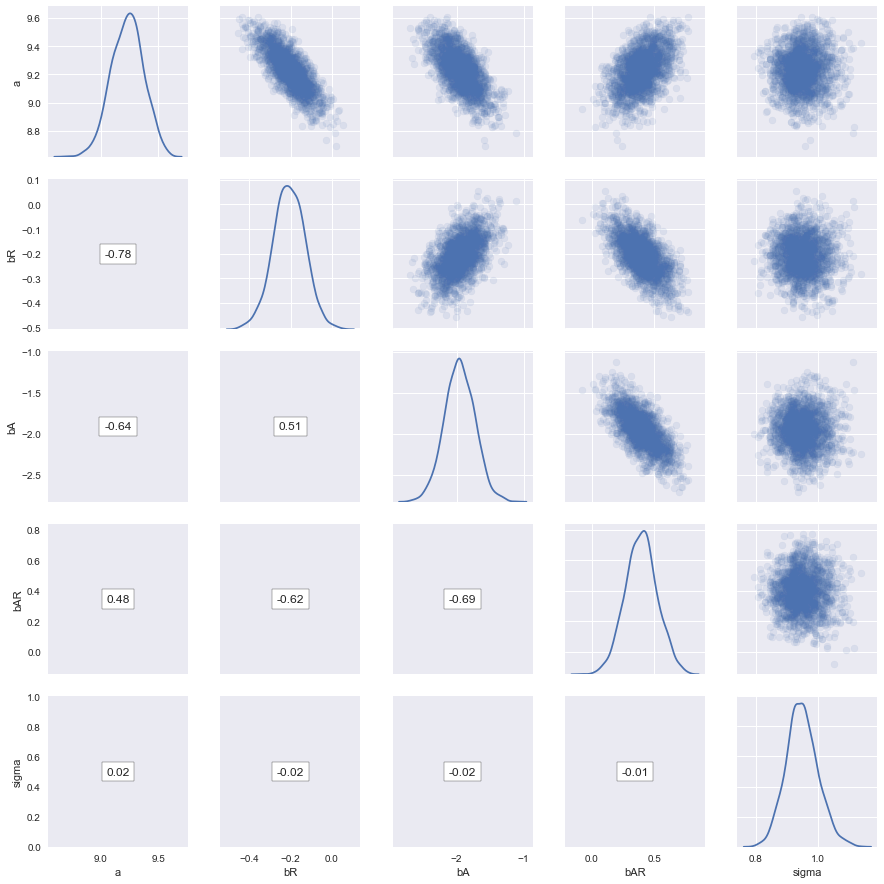

In [12]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

grid = (sns.PairGrid(data=post,
                     diag_sharey=False)
        .map_diag(sns.kdeplot)
        .map_upper(plt.scatter, alpha=0.1)
        .map_lower(plot_corr))

### 8.11

In [13]:
m8_1stan

In [14]:
pm.waic(trace8_1stan, m8_1stan)

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=468.93142031512366, WAIC_se=14.80795613396607, p_WAIC=4.9246716194805495, var_warn=1)

### 8.12

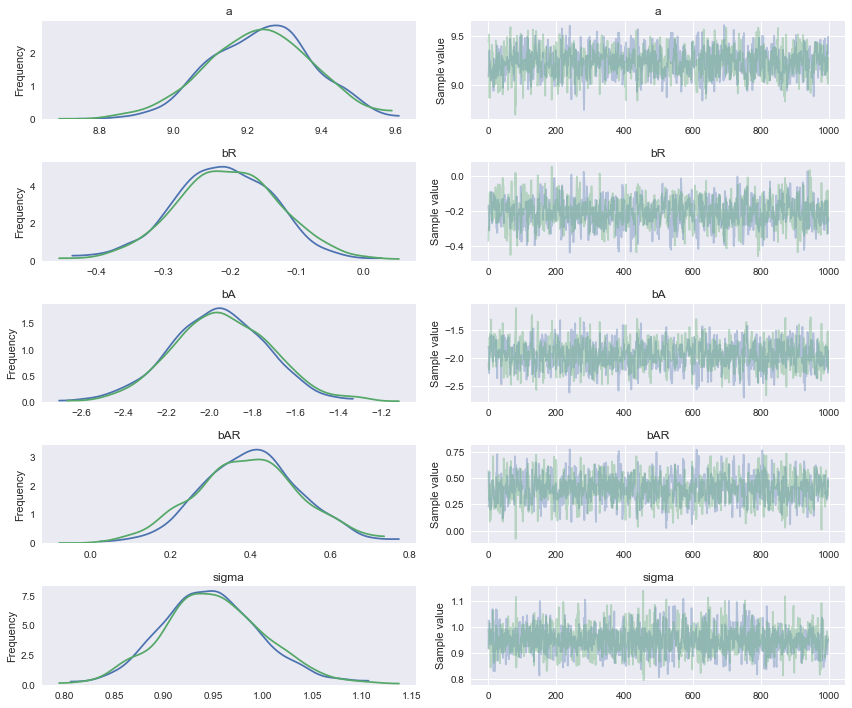

In [15]:
pm.traceplot(trace8_1stan, varnames=["a", "bR", "bA", "bAR", "sigma"]);

## Care and Feeding of your Markov Chain

### 8.13

In [16]:
y = np.array([-1, 1])
with pm.Model() as m8_2:
    sigma = pm.Bound(pm.Flat, lower=0)("sigma") # https://docs.pymc.io/api/bounds.html
    alpha = pm.Flat("alpha")
    y_obs = pm.Normal("y_obs", mu=alpha, sd=sigma, observed=y)
    trace8_2 = pm.sample(draws=4000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma]
Sampling 2 chains: 100%|██████████| 10000/10000 [02:24<00:00, 45.73draws/s]
There were 1077 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5248186595435045, but should be close to 0.8. Try to increase the number of tuning steps.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### 8.14

In [17]:
(pm.summary(trace8_2, alpha=0.11)
 .round(2))

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-2.137760e+15,2.047343e+16,1.204463e+15,-4.617553e+15,3.123683e+15,189.72,1.01
sigma,4.498013e+16,1.114821e+18,2.360279e+16,3.463204e+09,1.121509e+16,1717.40,1.00


### 8.15

In [18]:
with pm.Model() as m8_3:
    sigma = pm.HalfCauchy("sigma", 1)
    alpha = pm.Normal("alpha", mu=1, sd=10)
    y_obs = pm.Normal("y_obs", mu=alpha, sd=sigma, observed=y)
    trace8_3 = pm.sample(draws=4000, tune=1000)

(pm.summary(trace8_3, alpha=0.11)
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, sigma]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:07<00:00, 1343.61draws/s]
The acceptance probability does not match the target. It is 0.8788841956540845, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-0.04,1.82,0.05,-2.29,2.80,1281.25,1.0
sigma,2.20,2.23,0.06,0.45,3.99,1366.67,1.0


### 8.16

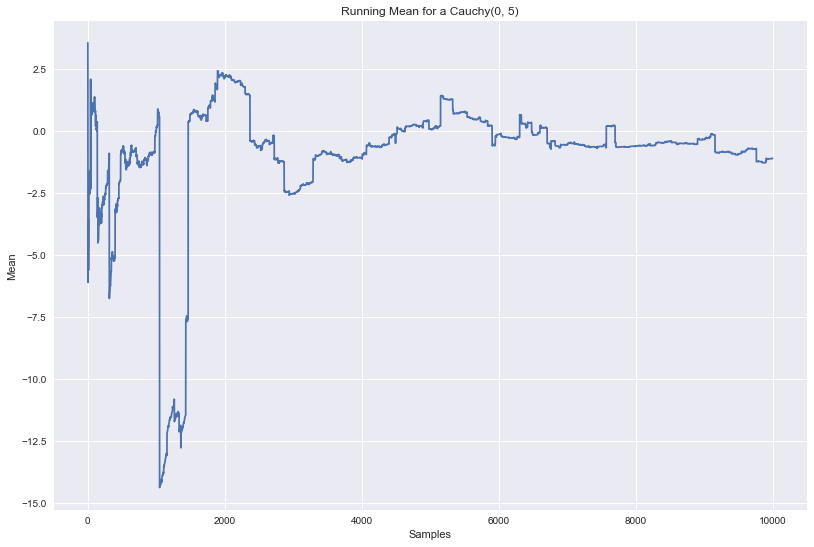

In [19]:
y = stats.cauchy.rvs(loc=0, scale=5, size=int(1e4))
mu = y.cumsum()/(1 + np.arange(int(1e4)))

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(mu)
ax.set_title("Running Mean for a Cauchy(0, 5)")
ax.set_xlabel("Samples")
ax.set_ylabel("Mean");

### 8.17

In [20]:
y = stats.norm.rvs(loc=0, scale=1, size=100)

### 8.18

In [21]:
with pm.Model() as m8_4:
    sigma = pm.HalfCauchy("sigma", 1)
    a1 = pm.Flat("a1")
    a2 = pm.Flat("a2")
    mu = pm.Deterministic("mu", a1 + a2)
    y_obs = pm.Normal("y_obs", mu=mu, sd=sigma, observed=y)
    trace8_4 = pm.sample(draws=2000, tune=500) # Takes too long with 4000, 1000

(pm.summary(trace8_4, alpha=0.11, varnames=["sigma", "a1", "a2"])
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2, a1, sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [04:43<00:00,  7.61draws/s]
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43287318601514735, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.663610858204607, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
sigma,1.00,0.06,0.00,0.90,1.10,2.83,1.35
a1,149.82,1707.70,170.34,-2342.91,2518.55,1.17,3.04
a2,-149.77,1707.70,170.34,-2518.57,2342.92,1.17,3.04


### 8.19

In [22]:
with pm.Model() as m8_5:
    sigma = pm.HalfCauchy("sigma", 1)
    a1 = pm.Normal("a1", mu=0, sd=10)
    a2 = pm.Normal("a2", mu=0, sd=10)
    mu = pm.Deterministic("mu", a1 + a2)
    y_obs = pm.Normal("y_obs", mu=mu, sd=sigma, observed=y)
    trace8_5 = pm.sample(draws=4000, tune=1000)

(pm.summary(trace8_5, alpha=0.11, varnames=["sigma", "a1", "a2"])
 .round(2))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a2, a1, sigma]
Sampling 2 chains: 100%|██████████| 10000/10000 [02:31<00:00, 35.02draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
sigma,0.97,0.07,0.00,0.86,1.08,3283.84,1.0
a1,-0.01,7.26,0.14,-11.84,11.48,2704.29,1.0
a2,0.05,7.26,0.14,-11.61,11.72,2703.66,1.0


## Practice

### Easy

#### 8E1.

The Metropolis algorithm doesn't need discrete parameters or a Gaussian Likelihood, it does require that the proposal distribution be symmetric, i.e. that the probability of going Clockwise or Anticlockwise in the island example is the same, but a modification, Metropolis-Hastings doesn't need have this requirement.

#### 8E2.

Gibbs Sampling is more efficent than Metropolis Sampling by sampling proposals from conjugate priors, i.e. if you know the shape of the likelihood for the prior you're using, you know what the shape of the posterior looks like. 

Gibbs Sampling constrains the priors you can use since not every prior is a conjugate prior, it also becomes inefficient as the models become more complex.

#### 8E3.

Hamiltonian Monte Carlo can't handle discrete parameters since it uses the rate of change (or the differential) to modify how far it jumps, discrete parameters are non differentiable and so HMC can't work with them.

#### 8E4.

Since sequential samples tend not to be independent, i.e. the next sample depends on the value of the current one, not all samples are equally useful, `n_eff` gives an estimate of the "effective number of samples", after removing  this _autocorrelation_.

#### 8E5.

Rhat is the Gelman-Rubin measure for convergence and approaches 1 from the right.

#### 8E6.

A good trace plot for a few chains should have the chains all convering around a posterior distribution (most samples from the densest part, few samples from the tails). 

Malfunctioning Markov chains would seem to come from different distributions and would not converge.

### Medium

#### 8M1.

In [23]:
rd = (pd.read_csv("data/rugged.csv", delimiter=";")
      .dropna(subset=["rgdppc_2000"])
      .assign(log_gdp=lambda df: np.log(df["rgdppc_2000"])))

In [24]:
with pm.Model() as m8m_1:
    sigma = pm.Uniform("sigma", 0, 10)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_1 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m8m_2:
    sigma = pm.Exponential("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 739.45draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 751.56draws/s]


In [25]:
data = (pd.concat([(pm.summary(trace8m_1, alpha=0.11, varnames=["sigma", "bAR", "bA", "bR", "a"])
                    [["mean", "hpd_5.5", "hpd_94.5"]]
                    .assign(model="8m_1")),
                   (pm.summary(trace8m_2, alpha=0.11, varnames=["sigma", "bAR", "bA", "bR", "a"])
                    [["mean", "hpd_5.5", "hpd_94.5"]]
                    .assign(model="8m_2"))])
        .reset_index()
        .set_index(["index", "model"]))

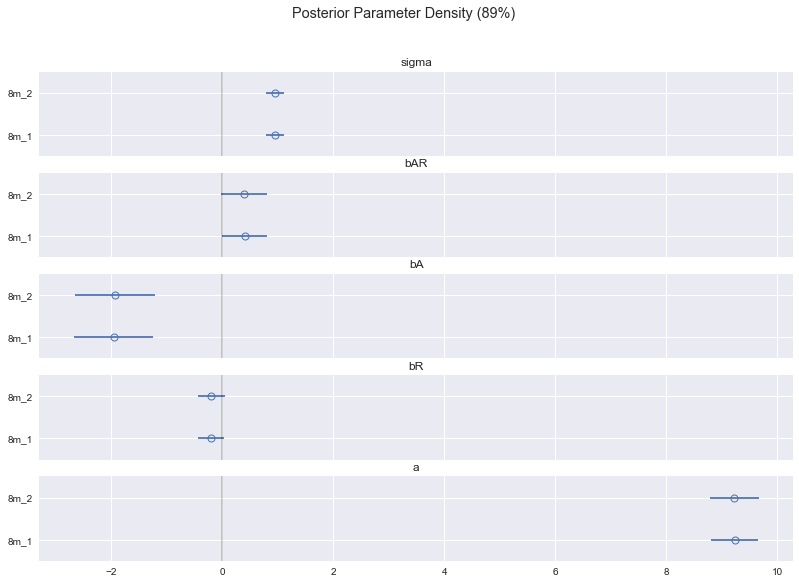

In [26]:
f, axs = plt.subplots(5, 1, sharex=True)
f.set_size_inches(13.5, 9)

f.suptitle("Posterior Parameter Density (89%)")
for (idx, varname) in enumerate(["sigma", "bAR", "bA", "bR", "a"]):
    axs[idx].errorbar(data.loc[varname]["mean"], data.loc[varname].index, fmt="o", 
                      xerr=data.loc[varname]["hpd_94.5"] - data.loc[varname]["hpd_5.5"], 
                      mew=1, mfc="None")
    axs[idx].vlines(0, ymin=-1, ymax=4, alpha=0.2)
    axs[idx].set_ylim(-0.5, 1.5)
    axs[idx].set_title(varname)

At least from the posterior distributions of the parameters for either model, there doesn't seem like there's a noticeable effect.

#### 8M2.

In [27]:
pm.summary(trace8m_1, varnames=["sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
sigma,0.948592,0.054244,0.00137,0.865658,1.032864,1573.682627,1.000951


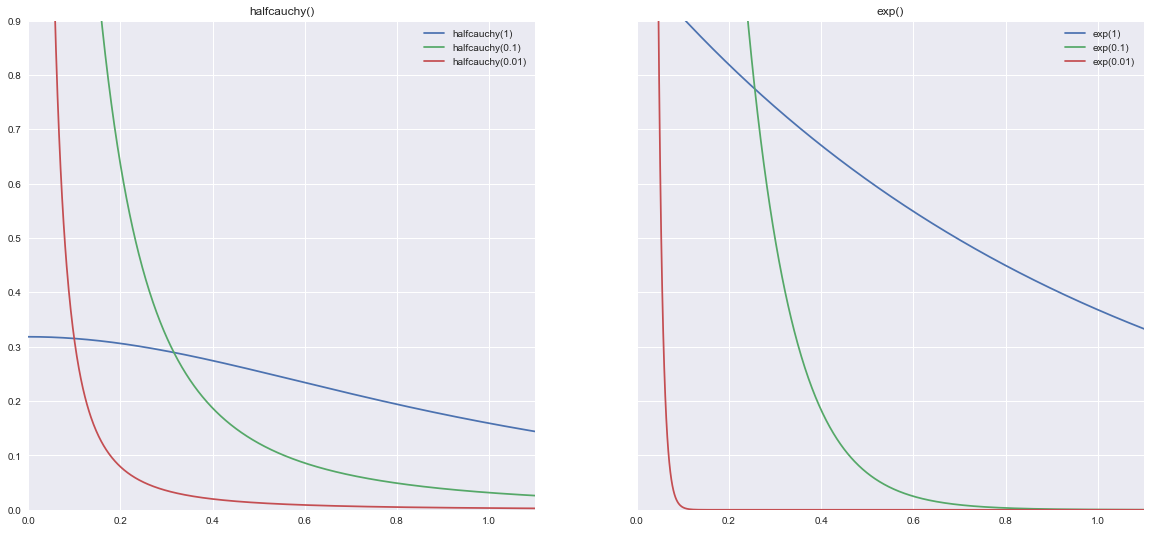

In [28]:
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 9)

xs = np.linspace(0, 1.1, 1000)
axs[0].plot(xs, stats.cauchy(0, 1).pdf(xs))
axs[0].plot(xs, stats.cauchy(0, 0.1).pdf(xs))
axs[0].plot(xs, stats.cauchy(0, 0.01).pdf(xs))
axs[0].set_ylim(0, 0.9)
axs[0].set_xlim(0, 1.1)
axs[0].legend(["halfcauchy(1)", "halfcauchy(0.1)", "halfcauchy(0.01)"])
axs[0].set_title("halfcauchy()");

axs[1].plot(xs, stats.expon(0, 1).pdf(xs))
axs[1].plot(xs, stats.expon(0, 0.1).pdf(xs))
axs[1].plot(xs, stats.expon(0, 0.01).pdf(xs))
axs[1].set_xlim(0, 1.1)
axs[1].legend(["exp(1)", "exp(0.1)", "exp(0.01)"])
axs[1].set_title("exp()");

In [29]:
with pm.Model() as m8m_3:
    sigma = pm.HalfCauchy("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_3 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m8m_4:
    sigma = pm.Exponential("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_4 = pm.sample(draws=1000, tune=1000)

with pm.Model() as m8m_5:
    sigma = pm.HalfCauchy("sigma", 0.1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_5 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m8m_6:
    sigma = pm.Exponential("sigma", 0.1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_6 = pm.sample(draws=1000, tune=1000)

# Fails With: ValueError: Mass matrix contains zeros on the diagonal. 
# with pm.Model() as m8m_7:
#     sigma = pm.HalfCauchy("sigma", 0.01)
#     bAR = pm.Normal("bAR", mu=0, sd=10)
#     bA = pm.Normal("bA", mu=0, sd=10)
#     bR = pm.Normal("bR", mu=0, sd=10)
#     a = pm.Normal("a", mu=0, sd=100)
#     mu = pm.Deterministic("mu", a +\
#                                 bR*rd["rugged"] +\
#                                 bA*rd["cont_africa"] +\
#                                 bAR*rd["rugged"]*rd["cont_africa"])
#     log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
#     trace8m_7 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m8m_8:
    sigma = pm.Exponential("sigma", 0.01)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_8 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 668.62draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 711.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 747.27draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 785.00draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 cha

In [30]:
acc = []
for (model, trace) in [("8m_3", trace8m_3),
                       ("8m_4", trace8m_4),
                       ("8m_5", trace8m_5),
                       ("8m_6", trace8m_6),
                       ("8m_8", trace8m_8)]:
    acc.append(pm.summary(trace, alpha=0.11, varnames=["sigma", "bAR", "bA", "bR", "a"])
               [["mean", "hpd_5.5", "hpd_94.5"]]
               .assign(model=model))

data = (pd.concat(acc)
        .reset_index()
        .set_index(["index", "model"]))

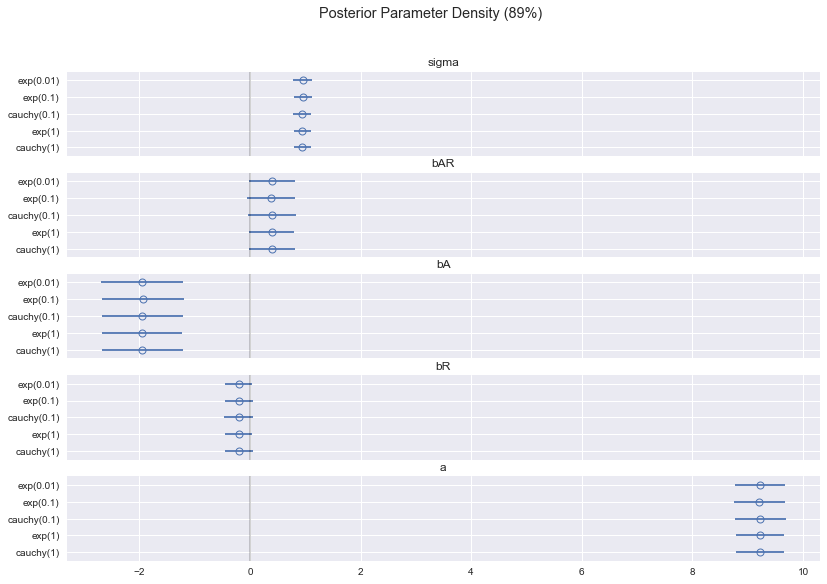

In [31]:
f, axs = plt.subplots(5, 1, sharex=True)
f.set_size_inches(13.5, 9)

f.suptitle("Posterior Parameter Density (89%)")
for (idx, varname) in enumerate(["sigma", "bAR", "bA", "bR", "a"]):
    axs[idx].errorbar(data.loc[varname]["mean"], data.loc[varname].index, fmt="o", 
                      xerr=data.loc[varname]["hpd_94.5"] - data.loc[varname]["hpd_5.5"], 
                      mew=1, mfc="None")
    axs[idx].vlines(0, ymin=-1, ymax=5, alpha=0.2)
    axs[idx].set_ylim(-0.5, 4.5)
    axs[idx].set_title(varname)
    axs[idx].set_yticklabels(["cauchy(1)", "exp(1)", "cauchy(0.1)", "exp(0.1)", "exp(0.01)"])

Even with ever tighter priors for sigma, I end up with mostly equivalent posteriors. This could be a case of the data overriding the prior.

#### 8M3

In [32]:
with pm.Model() as m8m_9:
    sigma = pm.HalfCauchy("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_9 = pm.sample(draws=1000, tune=0)
    
with pm.Model() as m8m_10:
    sigma = pm.HalfCauchy("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_10 = pm.sample(draws=1000, tune=10)

with pm.Model() as m8m_11:
    sigma = pm.HalfCauchy("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_11 = pm.sample(draws=1000, tune=100)

with pm.Model() as m8m_12:
    sigma = pm.HalfCauchy("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_12 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m8m_13:
    sigma = pm.HalfCauchy("sigma", 1)
    bAR = pm.Normal("bAR", mu=0, sd=10)
    bA = pm.Normal("bA", mu=0, sd=10)
    bR = pm.Normal("bR", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bR*rd["rugged"] +\
                                bA*rd["cont_africa"] +\
                                bAR*rd["rugged"]*rd["cont_africa"])
    log_gdp = pm.Normal("log_gdp", mu=mu, sd=sigma, observed=rd["log_gdp"])
    trace8m_13 = pm.sample(draws=1000, tune=10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:00<00:00, 2204.04draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, bAR, sigma]
Sampling 2 chains: 100%|██████████| 2020/2020 [00:03<00:00, 590.12draws/s]
There was 1 divergence

In [33]:
acc = []
for (model, trace) in [("8m_9", trace8m_9),
                       ("8m_10", trace8m_10),
                       ("8m_11", trace8m_11),
                       ("8m_12", trace8m_12),
                       ("8m_13", trace8m_13)]:
    acc.append(pm.summary(trace, alpha=0.11, varnames=["sigma", "bAR", "bA", "bR", "a"])
               .assign(model=model))

data = (pd.concat(acc)
        .reset_index()
        .set_index(["index", "model"])
        [["n_eff"]]
        .fillna(0))

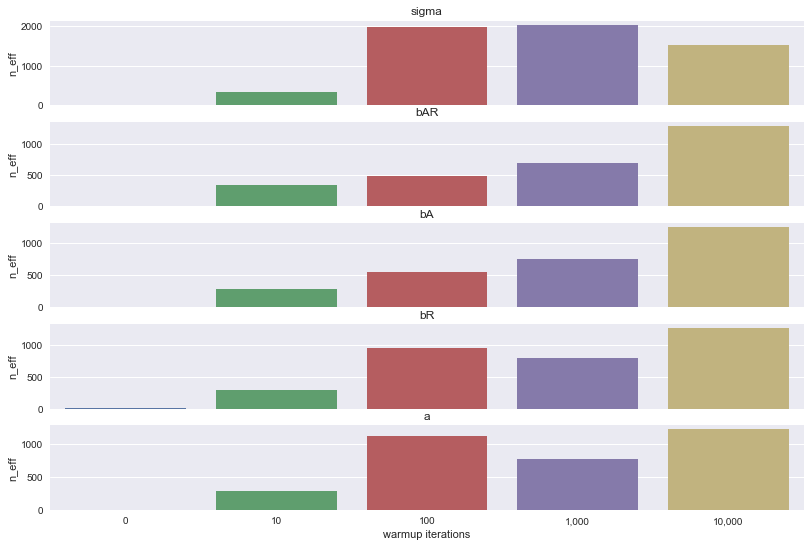

In [34]:
f, axs = plt.subplots(5, 1, sharex=True)
f.set_size_inches(13.5, 9)

for (idx, varname) in enumerate(["sigma", "bAR", "bA", "bR", "a"]):
    sns.barplot(data=data.loc[varname].reset_index(), x="model", y="n_eff", ax=axs[idx])
    axs[idx].set_title(varname)
    axs[idx].set_xlabel("")

axs[-1].set_xticklabels(["0", "10", "100", "1,000", "10,000"])
axs[-1].set_xlabel("warmup iterations");

It does look like `n_eff` is non linear in the number of warmup iterations, in fact it looks like it plateaus after about a 1000 for this particular model.

### Hard

#### 8H1.

In [35]:
with pm.Model() as m8m_14:
    a = pm.Normal("a", 0, 1)
    b = pm.Cauchy("b", 0, 1)
    trace8m_14 = pm.sample(draws=10000, tune=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 20200/20200 [00:16<00:00, 1189.64draws/s]
The acceptance probability does not match the target. It is 0.6627045558803666, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


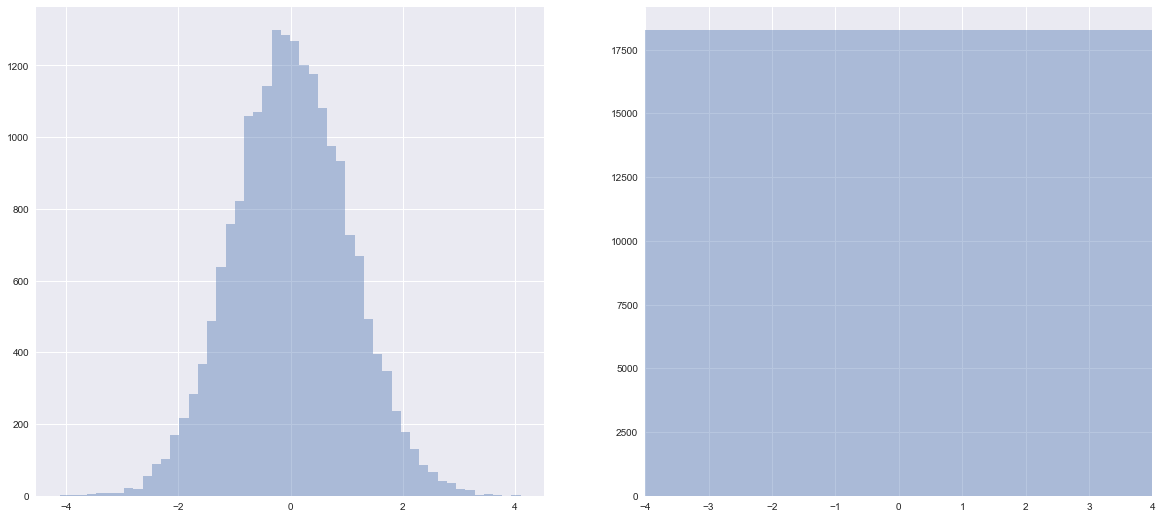

In [36]:
f, axs = plt.subplots(1, 2)
f.set_size_inches(20, 9);
xs = np.linspace(-4, 4, 1000)
sns.distplot(trace8m_14["a"], ax=axs[0], kde=False)
sns.distplot(trace8m_14["b"], ax=axs[1], kde=False)
axs[1].set_xlim(-4, 4);

It looks like the samples are drawn directly from the priors, which is what I expected.

#### 8H2.

In [37]:
dd = (pd.read_csv('Data/WaffleDivorce.csv', sep=';')
      .assign(MedianAgeMarriage_s=lambda df: (df["MedianAgeMarriage"] - df["MedianAgeMarriage"].mean())/\
                                              df["MedianAgeMarriage"].std())
      .assign(Marriage_s=lambda df: (df["Marriage"] - df["Marriage"].mean())/\
                                     df["Marriage"].std()))

In [38]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA*dd["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=dd["Divorce"])
    trace_5_1 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bR = pm.Normal("bR", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR*dd["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=dd["Divorce"])
    trace_5_2 = pm.sample(draws=1000, tune=1000)
    
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a +\
                                bR*dd["Marriage_s"] +\
                                bA*dd["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=dd["Divorce"])
    trace_5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1462.71draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1515.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1151.73draws/s]


In [39]:
(pm.compare({m5_1 : trace_5_1,
             m5_2 : trace_5_2,
             m5_3 : trace_5_3},
            method='pseudo-BMA')
 .join(pd.Series(["m5_1", "m5_2", "m5_3"], name="model"))
 .set_index("model")
 .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m5_1,186.08,3.75,0,0.71,12.4,0,1
m5_3,187.92,4.87,1.84,0.28,12.47,0.8,1
m5_2,199.67,3.07,13.59,0,9.54,8.98,1


Interestingly, the model predicting divorce rate solely by Median Age of Marriage has a lower WAIC than the one that additionally uses Marriage Rate.

This is probably a sign that the added model complexity does not compensate enough in prediction accuracy.

#### 8H3.

### 8.21

In [40]:
N = 100
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height, 
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 8.22

In [41]:
with pm.Model() as m5_8s:
    sigma = pm.HalfCauchy("sigma", 1)
    bR = pm.Normal("bR", mu=2, sd=10)
    bL = pm.Normal("bL", mu=2, sd=10)    
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bL*d["leg_left"] +\
                                bR*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8s = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bL, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:17<00:00, 11.56draws/s]


### 8.23

In [42]:
with pm.Model() as m5_8s2:
    sigma = pm.HalfCauchy("sigma", 1)
    bR = pm.Bound(pm.Normal, lower=0)("bR", mu=2, sd=10)
    bL = pm.Normal("bL", mu=2, sd=10)    
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a +\
                                bL*d["leg_left"] +\
                                bR*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8s2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bL, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:00<00:00, 65.90draws/s] 
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [43]:
acc = []
for (model, trace) in [("m5_8s", trace_5_8s),
                       ("m5_8s2", trace_5_8s2)]:
    acc.append(pm.summary(trace, alpha=0.11, varnames=["sigma", "bR", "bL", "a"])
               [["mean", "hpd_5.5", "hpd_94.5"]]
               .assign(model=model))

data = (pd.concat(acc)
        .reset_index()
        .set_index(["index", "model"]))

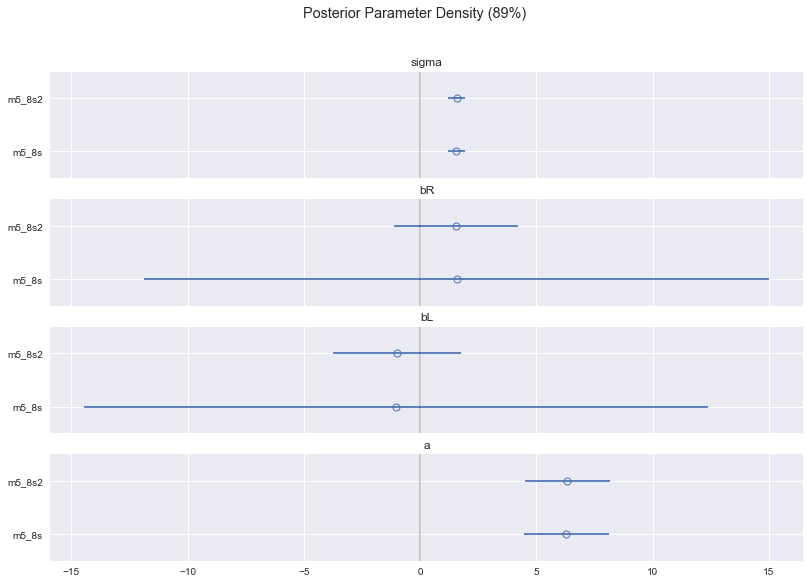

In [44]:
f, axs = plt.subplots(4, 1, sharex=True)
f.set_size_inches(13.5, 9)

f.suptitle("Posterior Parameter Density (89%)")
for (idx, varname) in enumerate(["sigma", "bR", "bL", "a"]):
    axs[idx].errorbar(data.loc[varname]["mean"], data.loc[varname].index, fmt="o", 
                      xerr=data.loc[varname]["hpd_94.5"] - data.loc[varname]["hpd_5.5"], 
                      mew=1, mfc="None")
    axs[idx].vlines(0, ymin=-1, ymax=3, alpha=0.2)
    axs[idx].set_ylim(-0.5, 1.5)
    axs[idx].set_title(varname)

Since leg_left and leg_right are strongly correlated, the values for bR and bL are tightly bound, by setting a more restrictive prior on bR I've implicitly set a more restrictive prior for bL.

#### 8H4.

In [45]:
(pm.compare({m5_8s : trace_5_8s,
             m5_8s2 : trace_5_8s2},
            method='pseudo-BMA')
 .join(pd.Series(["m5_8s", "m5_8s2"], name="model"))
 .set_index("model")
 .sort_values("WAIC"))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
model,,,,,,,
m5_8s2,374.87,2.66,0,0.68,15.12,0,0
m5_8s,376.41,3.41,1.53,0.32,15.44,0.4,1


`m5_8s` has 3.05 effective parameters compared to only 1.76 for `m5_8s2`, the effective number of parameters is a measure of the flexibility of the model and stronger priors reduce model flexiblity.

#### 8H5.

In [46]:
def metropolis(islands, weeks):
    """
    given a list of island populations and the number of weeks
    returns the king's tour according to the metropolis algorithm
    """
    current = 0
    tour = []
    for _ in range(num_weeks):
        proposal = (current + np.random.choice([-1, 1])) % len(islands)
        prob_move = islands[proposal]/islands[current]
        current = proposal if np.random.uniform() < prob_move else current
        tour.append(current)
    return tour

In [47]:
tour_1 = metropolis([1, 10, 100, 1000, 10000], int(1e5))
tour_2 = metropolis([5, 4, 3, 2, 1], int(1e5))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


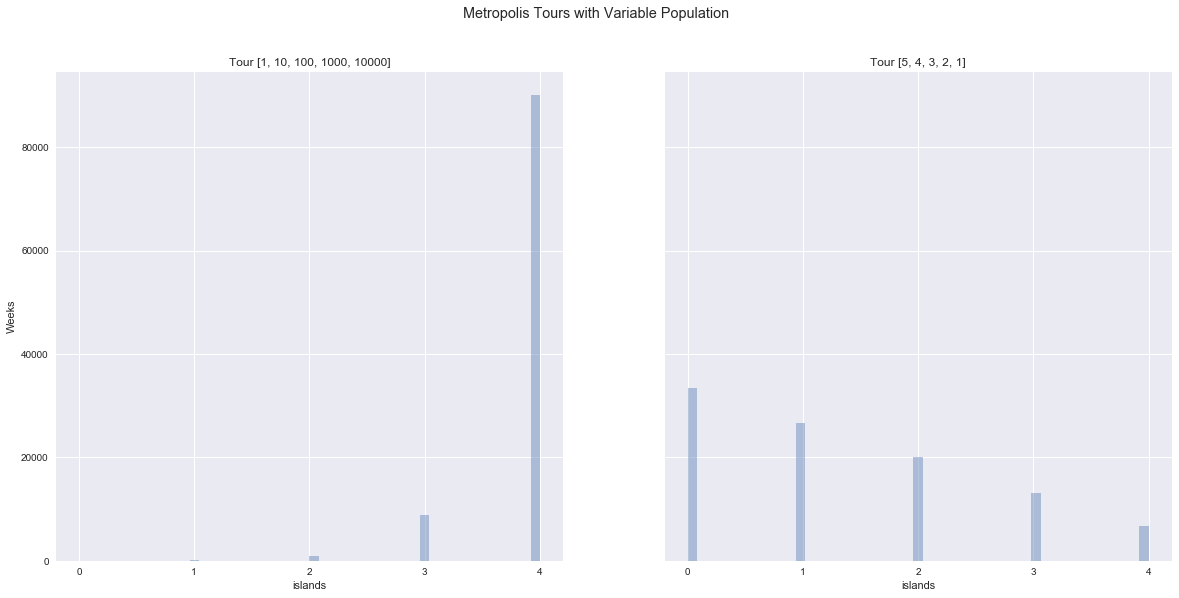

In [48]:
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(20, 9)
sns.distplot(tour_1, kde=False, ax=axs[0])
sns.distplot(tour_2, kde=False, ax=axs[1])
axs[0].set_title("Tour [1, 10, 100, 1000, 10000]")
axs[0].set_xticks(range(5))
axs[0].set_xlabel("islands")
axs[0].set_ylabel("Weeks")
axs[1].set_title("Tour [5, 4, 3, 2, 1]")
axs[1].set_xticks(range(5))
axs[1].set_xlabel("islands")
f.suptitle("Metropolis Tours with Variable Population");

#### 8H6.

In [49]:
def mcmc(prior, num_successes, num_failures, iterations):
    """
    given a prior as a list of probability mass, where the array index/len(array)
    is the value of theta (the binomial parameter to predict), the number
    of successes and failures and the number of iterations
    returns the steps taken in a list.
    """
    current = 0
    num_trials = num_successes + num_failures
    steps = []
    for _ in range(num_weeks):
        proposal = (current + np.random.choice([-1, 1])) % len(prior)
        current_theta = current/len(prior)
        proposal_theta = proposal/len(prior)
        current_likelihood = stats.binom.pmf(num_successes, num_trials, current_theta)
        proposal_likelihood = stats.binom.pmf(num_successes, num_trials, proposal_theta)
        prob_move = proposal_likelihood/current_likelihood
        (current, theta) = (proposal, proposal_theta) if np.random.uniform() < prob_move else (current, current_theta)
        steps.append(theta)
    return steps

In [50]:
# for observations WLWWWLWLW where W is a success
steps = mcmc(np.ones(101)/101, 6, 3, int(1e6))

/Users/sgodiwala/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


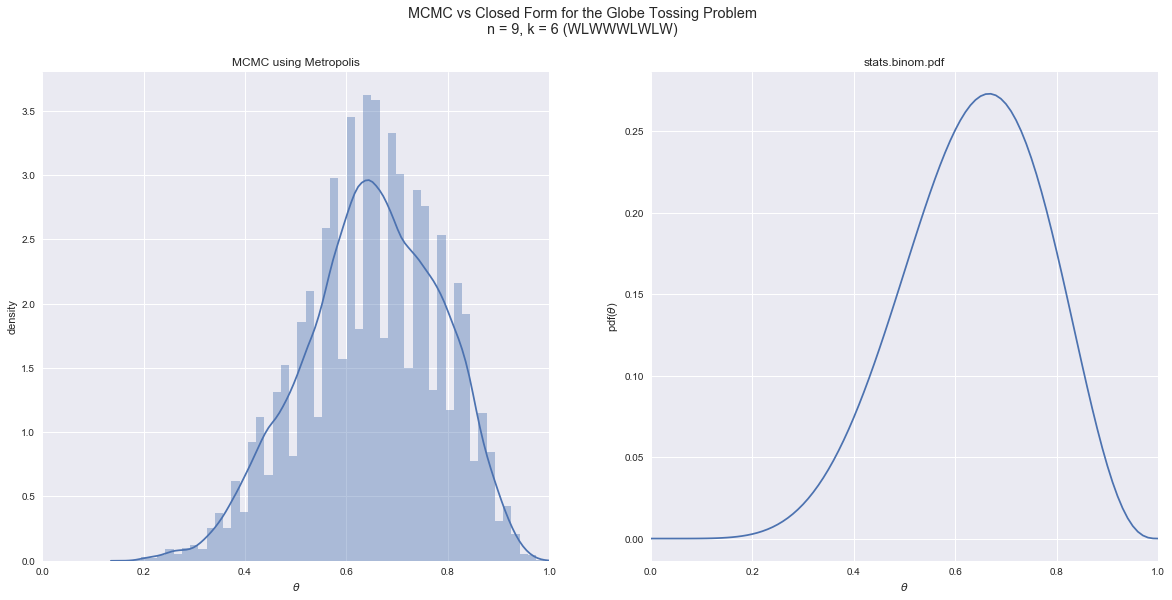

In [51]:
xs = np.linspace(0, 1, 101)
ys = stats.binom.pmf(6, 9, xs)

f, axs = plt.subplots(1, 2)
f.set_size_inches(20, 9)
sns.distplot(steps, hist=True, kde=True, ax=axs[0])
axs[0].set_xlim(0, 1)
axs[0].set_xlabel("$\\theta$")
axs[0].set_ylabel("density")
axs[0].set_title("MCMC using Metropolis")
axs[1].plot(xs, ys)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel("$\\theta$")
axs[1].set_ylabel("pdf($\\theta$)")
axs[1].set_title("stats.binom.pdf")
f.suptitle("MCMC vs Closed Form for the Globe Tossing Problem\n"
           "n = 9, k = 6 (WLWWWLWLW)");